In [36]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
from operator import attrgetter
from IPython.display import Image
%matplotlib inline
np.set_printoptions(precision=8)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [37]:
def safe_log_sum_exp(x):
    max_const = np.max(x)
    log_sum_exp = np.log(np.sum(np.exp(x - max_const)))
    return log_sum_exp + max_const

# A TUTORIAL ON CHANGEPOINT MODELS

This tutorial describes the implementation of multiple change point models(CPM). CPM's are hierarchical hidden Markov models with the following generative model:


\begin{align}
\pi_0  &\sim p(\pi_0) \\
r_1  &\sim p(r_1) \\
r_t  &\sim p(r_t|r_{t-1}) \\
\pi_t  &\sim p(\pi_t|r_t,\pi_{t-1}) \\
x_t  &\sim p(x_t|r_t,\pi_t)
\end{align}

Here, $r_t$ and $\pi_t$ are two Markov chains where $\pi_t$ is conditioned on $r_t$, which is said to _control_ $\pi_t$ and observations $x_t$ are conditioned only on $\pi_t$. When the state space of $\pi_t$ is discrete, this model is reduced to a hidden Markov model whose state space is the cartesian product of $r_t$ and $\pi_t$'s state spaces. When $\pi_t$ is continuous, however, forward-backward algorithm cannot be implemented in general.

In this tutorial, we will focus on a special kind of changepoint models that are called _reset_ models. In such models, $r_t$ is a binary variable. When $r_t=0$, $\pi_t$ stays the same as $\pi_{t-1}$. When $r_t=1$, the model is said to _reset_ itself, that is, $\pi_t$ becomes independent of $\pi_{t-1}$ and is set to a random variable generated from its hyperparameter. As we will see below, linear time algorithms can be derived thanks to this property. We also remove the dependency between $r_t$ and assume that they are independent from one another. So, the graphical model is

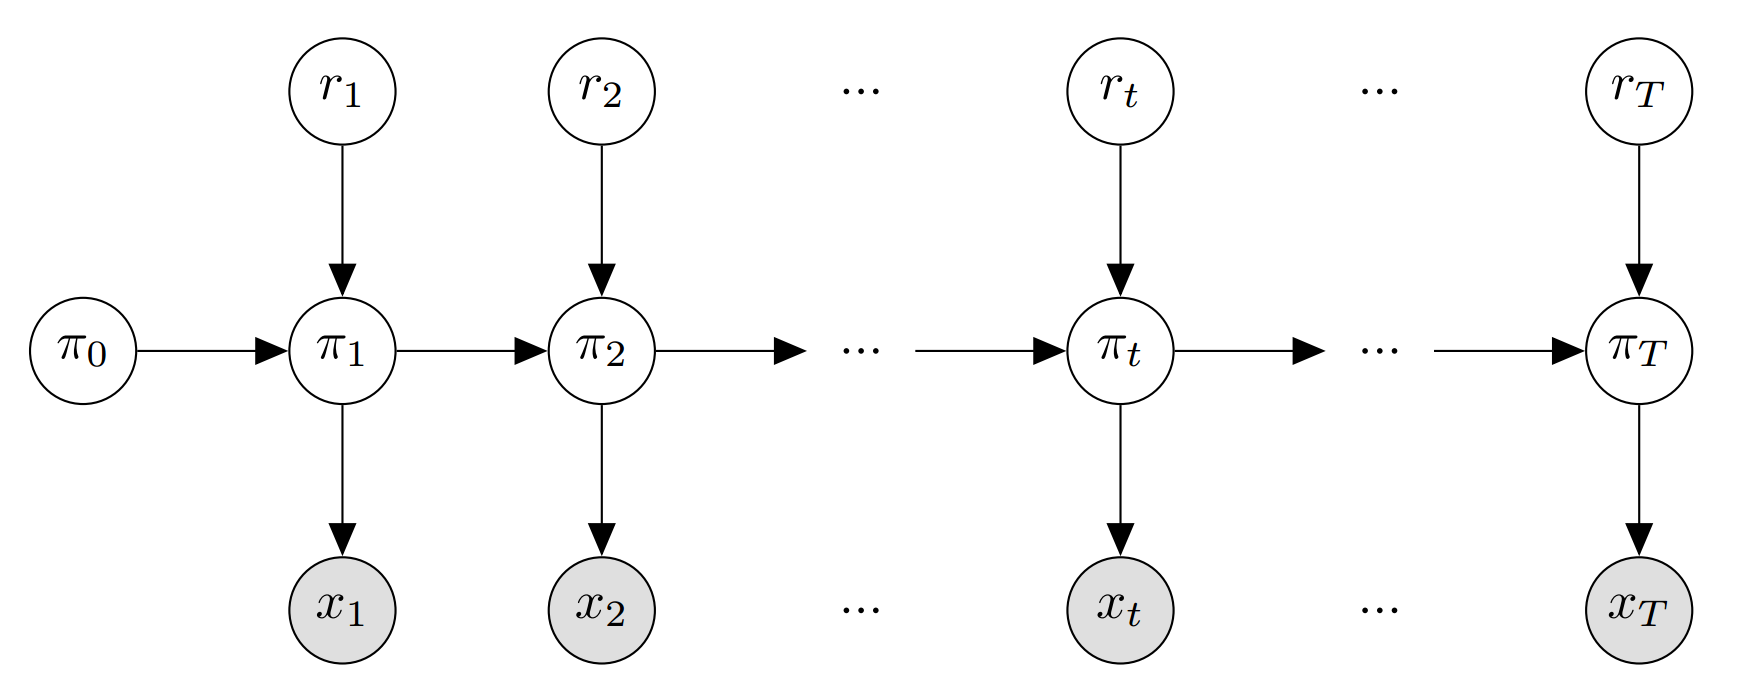

In [38]:
Image(filename='graphical_model.png', width=600, height=200)

# Inference in CPM's

We can calculate the posterior marginals of the hidden variables $r_{1:T}$, and $\pi_{0:T}$, therefore detect the \emph{change points}, via the _Forward-Backward_ algorithm, provided that the model parameters $a$ and $p$ is known.

### Filtering (Forward Recursion)

We can infer the latent states ${r_t, \pi_t}$ at time $t$ by considering the observation until then $x_{0:t}$ with filtering. The filtering density is defined by $\alpha_{t|t}$ as:

\begin{align}
	\alpha_{t|t}(r_t, \pi_t) &= p(r_t, \pi_t, x_{1:t})
\end{align}
and the filtering posterior at time $t$ is proportional to $\alpha_{t|t}(r_t, \pi_t)$:
\begin{align}
	 p(r_t, \pi_t | x_{1:t}) \propto \alpha_{t|t}(r_t, \pi_t)
\end{align}

We calculate the $\alpha$ messages recursively as follows:

\begin{align}
	\alpha_{t|t}(r_t, \pi_t) &= p(r_t, \pi_t, x_{1:t}) \\
    &= p(x_t | r_t, \pi_t) \sum_{r_{t-1}} \int_{\pi_{t-1}} p(r_{t-1}, \pi_{t-1}, x_{1:{t-1}}) p(r_t, \pi_t | r_{t-1}\pi_{t-1}) d \pi_{t-1}\\
    &= p(x_t | r_t, \pi_t) \underbrace{\sum_{r_{t-1}} \int_{\pi_{t-1}} \! \alpha_{t-1|t-1}(r_{t-1}, \pi_{t-1}) p(r_t, \pi_t | \pi_{t-1}) d \pi_{t-1}}_{\alpha_{t|t-1}(r_t, \pi_t)=p(r_t, \pi_t, x_{1:t-1})}
\end{align}

We also call $\alpha_{t|t-1}(r_t, \pi_t) = p(r_t, \pi_t, x_{1:t-1})$ as the _forward prediction message_. Therefore we move forward by calculating the prediction $\alpha_{t|t-1}$ and update messages $\alpha_{t|t}$ alternatively and propagate the posterior probabilities of latent states. And normalize $\alpha_{t|t}$ for the posterior distribution $p(r_t, \pi_t | x_{0:T})$ of latent states at time $t$ in order to make a change point decision.

### Backward Recursion

Let's define the backward messages:

\begin{align}
\beta_{t|t+1}(r_t, \pi_t) &= p(x_{t+1:T} | r_t, \pi_t) \\
\beta_{t|t}(r_t, \pi_t) &= p(x_{t:T} | r_t, \pi_t) 
\end{align}

The update equations are as follows:

\begin{align}
\beta_{t|t+1}(r_t, \pi_t) &= \sum_{r_{t+1}} \int_{\pi_{t+1}} \beta_{t+1|t+1}(r_{t+1}, \pi_{t+1}) p(r_{t+1}, \pi_{t+1} | \pi_{t}) d \pi_{t+1} \\
\beta_{t|t}(r_t, \pi_t) &= p(x_t | r_t, \pi_t)  \beta_{t|t+1}(r_t, \pi_t)
\end{align}

### Smoothing

The posteriors probabilities can be obtained by multiplying forward and backward messages:
\begin{align}
    p(r_t, \pi_t|x_{1:T}) &\propto  p(r_t, \pi_t,x_{1:T}) \\
                          &= p(r_t, \pi_t, x_{1:t}) p(x_{t+1:T} | r_t, \pi_t, x_{1:t}) \\
                          &= p(r_t, \pi_t, x_{1:t}) p(x_{t+1:T} | r_t, \pi_t) \\
                          &= \alpha_{t|t} \beta_{t|t+1}
\end{align}

If the inference task is online, calculating posterior probabilities conditioned to full history becomes infeasible. This is because the cost of executing backward recursions increases linearly with time and backward recursions must be executed at each new observation. For online problems we typically use _fixed lag smoothers_, in which a fixed number of backward recursions are performed so that the computational complexity stays the same. This fixed number is referred as **lag**. If the lag is **L**, posterior probabilites at time $t$ is calculated conditioned on the observations up to time $t+L$ as follows:


\begin{align}
	p(r_t, \pi_t, x_{1:t+L}) &= p(r_t, \pi_t, x_{0:t}) p(x_{t+1:L} | r_t, \pi_t) \\
	&= \alpha_{t|t}(r_t, \pi_t) \beta_{t|t+1} (r_t, \pi_t)
\end{align}

# Example: Dirichlet-Multinomial CPM

## Generative Model

In the example application, observations are $K>1$ dimensional. So we, set $\pi_0$ to a $K$ dimensional Dirichlet random variable with parameter $a$. We further assume that each observation $x_t$ is drawn from a Multinomial distribution parametrized by $\pi_t$. Because Dirichlet distribution is the conjugate prior of Multinomial, we will integrate out $\pi_t$ easily while calculating the posterior probability of a change. Overall, the generative model becomes


\begin{align}
\pi_0  &\sim \mathcal{D}ir(\pi_0; a) \\
r_t  &\sim \mathcal{BE}(r_t; c) \\
\pi_t | r_t, \pi_{t-1}  &\sim [r_{t}=0] \delta(\pi_{t} - \pi_{t-1}) + [r_{t}=1] \mathcal{D}ir(\pi_t; a)\\
x_t | \pi_t  &\sim \mathcal{M}(x_t; \pi_t)
\end{align}

and the Bernoulli, Dirichlet and Multinomial distributions are defined as

\begin{align}
	\mathcal{BE}(r; p) &=  \exp \left( r \log p + (1-r) \log (1-p)   \right) \\
	\mathcal{D}ir(\pi; a) &= \exp \left( \log \Gamma \left( \sum_{k=1}^K a_k \right) - \sum_{k=1}^K \Gamma(a_k)  + \sum_{k=1}^K (a_k-1) \log \pi_{k} \right) \\
    \mathcal{M}(x;\pi) &= \exp\left( \log (x_s!) - \sum_i \log(x_i!) + \sum_i x_i \log \pi_i \right), \quad\quad x_s = \sum_i x_i
\end{align}

Data generating code is given below:

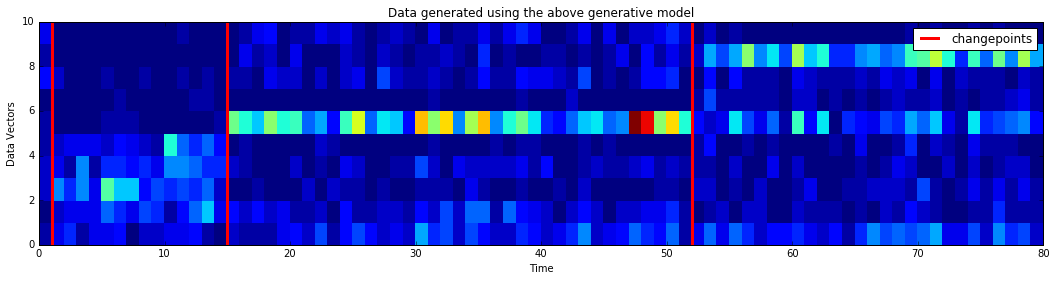

In [122]:
T = 80   # time index
K = 10   # input dimension
c = 0.05   # prior on change point probability 
# a = np.ones(K)/K    # hyperparameter of reset parameter
a = np.ones(K)    # hyperparameter of reset parameter

ch = np.random.binomial(1,r,size=T)
actual_changepoints = np.where(ch==1)[0]
pi_0 = np.random.dirichlet(a)
pi_ = np.zeros((K,T))
data = np.zeros((K,T))

for t in range(T):
    if ch[t]:
        pi_[:,t] = np.random.dirichlet(a)
    elif t==0:
        pi_[:,t] = pi_0
    else:
        pi_[:,t] = pi_[:,t-1]
    data[:,t] = np.random.multinomial(np.random.randint(10,50),pi_[:,t])

def plot_hist(data,xlines,title="",xlabel="",ylabel="",label_='changepoints'):
    (K,T) = data.shape
    fig = plt.figure(figsize=(18,4))
    ax = fig.gca()
    y,x = np.mgrid[slice(0, K+1, 1),slice(0,T+1, 1)]
    ax.pcolormesh(x, y, data)
    ax.hold(True)
    plt1 = ax.vlines(np.arange(0,T), 0, xlines*K, colors='r', linestyles='-',label=label_,linewidth='3')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(handles=[plt1])
    fig.canvas.draw()
    
plot_hist(data,ch,title="Data generated using the above generative model", xlabel="Time",ylabel="Data Vectors")
    

## Implementational Details

### Dirichlet Potential

Implementation of the multiple change point model with Multinomial observations and Dirichlet priors requires working in the continuous domain. Thus, we represent the posterior distribution on $\pi_t$ and $r_t$ using Dirichlet potentials. Also, because forward/backward recursions involve marginalization over $r_t$, $\alpha$ and $\beta$ messages are mixtures of Dirichlet potentials. At first glance, the number of mixture components may seem to grow with complexity $2^t$ (one component for each possible value of $r_t$). However, as we will see below, inference can be carried out in $O(t)$, both in terms of time and space complexity in _reset_ models. 

A Dirichlet potential is defined with a tuple $(\alpha, c)$ where $\alpha$ is a Dirichlet parameter and $c$ is the normalizing constant.

\begin{align*}
	\phi(x) &= e^c \mathcal{D}ir(x; \alpha) \\
	c &= \log \int_x \phi(x) dx
\end{align*}

Below data structure stores a mixture component in general. For Dirichlet-Multinomial CPM, a mixture component corresponds to a Dirichlet potential and therefore $\alpha$ is a vector and $c$ is a positive real number.  

In [40]:
class MixtureComponent:
    def __init__(self,alpha_,c_):
        self.alpha = alpha_
        self.c = c_
    def copy(self):
        return MixtureComponent(self.alpha.copy(), self.c)

Let us also define the shorthand for logarithms of change-point priors as

\begin{align}
l_0 = log(r_0) = \text{log} p(r_t=0)\\
l_1 = log(r_1) = \text{log} p(r_t=1)
\end{align}

We need to define two operations for the implementations: multiplication of two Dirichlet potentials and that of a Dirichlet potential and a Multinomial random variable, both of which results in a Dirichlet potential. The former is needed as we multiply forward and backward messages, which are Dirichlet potentials, for smoothing and the latter is used when we marginalize out $\pi_t$ in forward/backward algorithm. We will first show that multiplication of two Dirichlet potential yields another Dirichlet potential. Then, we will write Multinomial distribution as a Dirichlet potential, which in turn completes the second argument.

### Multiplication of Dirichlet Potentials

Multiplication of two Dirichlet potentials $(\alpha_1, c_1)$ and $(\alpha_2, c_2)$ is another Dirichlet potential:

\begin{align*}
	(\alpha_1, c_1) (\alpha_2, c_2) &= e^{c_1} \mathcal{D}ir(x; \alpha_1) e^{c_2} \mathcal{D}ir(x; \alpha_2) \\
	&= \exp \left (c_1 + c_2 +  \log \Gamma \left( \sum_{k=1}^K \alpha_{1,k} \right) - \sum_{k=1}^K \log \Gamma(\alpha_{1,k})  + \sum_{k=1}^K (\alpha_{1,k} - 1 ) \log x_{k} \right . \\
	&\qquad \left .  + \log \Gamma \left( \sum_{k=1}^K \alpha_{2,k} \right) - \sum_{k=1}^K \log  \Gamma(\alpha_{2,k})  + \sum_{k=1}^K (\alpha_{2,k}-1) \log x_{k} \right ) \\
	&= \exp \left (c_1 + c_2 +  \log \Gamma \left( \sum_{k=1}^K \alpha_{1,k} \right) - \sum_{k=1}^K \log \Gamma(\alpha_{1,k})  + \log \Gamma \left( \sum_{k=1}^K \alpha_{2,k} \right) - \sum_{k=1}^K \log \Gamma(\alpha_{2,k})  \right . \\
	& \qquad \left . + \sum_{k=1}^K  (\alpha_{1,k} + \alpha_{2,k} - 2) \log x_{k} \right ) \\
	&= (\alpha_1 + \alpha_2 - 1, g(\alpha_1, c_1, \alpha_2, c_2))
\end{align*}

where the new normalizing constant is 

\begin{align*}
	g(\alpha_1, c_1, \alpha_2, c_2) &=  c_1 + c_2 +  \log \Gamma \left( \sum_{k=1}^K \alpha_{1,k} \right) - \sum_{k=1}^K \log \Gamma(\alpha_{1,k})  + \log \Gamma \left( \sum_{k=1}^K \alpha_{2,k} \right) - \sum_{k=1}^K \log \Gamma(\alpha_{2,k})  \\
	&\qquad - \log \Gamma \left( \sum_{k=1}^K (\alpha_{1,k} + \alpha_{2,k} - 1) \right) + \sum_{k=1}^K \log \Gamma(\alpha_{1,k} + \alpha_{2,k} - 1)
\end{align*}

The code that calculates the normalizing constan resulting from the multiplicaion is below:

In [41]:
def dir_dir_norm_const(alpha1,alpha2):
    return  sp.gammaln(np.sum(alpha1)) - np.sum(sp.gammaln(alpha1)) + \
            sp.gammaln(np.sum(alpha2)) - np.sum(sp.gammaln(alpha2)) + \
            np.sum(sp.gammaln(alpha1+alpha2-1)) - sp.gammaln(np.sum(alpha1+alpha2-1))

### Multinomial Density as a Dirichlet Potential

We can define a Multinomial distribution as Dirichlet potential as follows:

\begin{align*}
	\mathcal{M}(x; \pi) &= \exp \left( \log \Gamma \left (1 + \sum_{k=1}^K x_k  \right) - \sum_{k=1}^K \log \Gamma (x_k +1) + \sum_{k=1}^K x_k \log \pi_k  \right) \\
	\mathcal{D}ir(\pi; x+1) &= \exp \left( \log \Gamma \left( \sum_{k=1}^K (x_k +1) \right) - \sum_{k=1}^K \log \Gamma(x_k + 1)  + \sum_{k=1}^K (x_k) \log \pi_{k} \right)
\end{align*}

then, we can write $\mathcal{M}(x; \pi)$ as the Dirichlet potential $(x+1, f(x))$ where $f(x)$ is the constant

\begin{align*}
	f(x) = \log \Gamma \left( 1 + \sum_{k=1}^K x_k  \right) - \log \Gamma \left( \sum_{k=1}^K (x_k +1) \right)
\end{align*}


In [42]:
def dir_mult_norm_const(alpha1,alpha2):
    return  sp.gammaln(np.sum(alpha1)+1) - np.sum(sp.gammaln(alpha1+1)) + \
            sp.gammaln(np.sum(alpha2))- np.sum(sp.gammaln(alpha2)) +\
            np.sum(sp.gammaln(alpha1+alpha2)) - sp.gammaln(np.sum(alpha1+alpha2))

### Calculation of $p(r_t)$ and $p(\pi_t)$ from a Mixture of Dirichlet Potentials

To track the density of $\pi_t$ and the probability of a change, we need to calculate $p(r_t)$ and $p(\pi_t)$. If we express a forward message as the summation of components with the following notation:
\begin{align*}
	\alpha_{t|t}(r_t, \pi_t) &= \sum_i \alpha_{t|t}^i(r_t, \pi_t)
\end{align*}
The expectation of filtered intensity becomes
\begin{align*}
	\langle p(\pi_t, x_{1:t}) \rangle &= \langle \sum_{r_t} p(\pi_t, r_t, x_{1:t}) \rangle \\
	&= \langle \sum_i \alpha_{t|t}^i(r_t, \pi_t) \rangle \\
    &= \langle \sum_i \mathcal{D}ir(\pi_t^i;a_t^i) \mathcal{C}_t^i \rangle \\
    &= \sum_i \mathcal{C}_t^i \langle \mathcal{D}ir(\pi_t^i;a_t^i)  \rangle \\
\end{align*}
noting that if $\pi \sim \mathcal{D}ir(\pi;a)$, then $E[\pi] = a/\sum_j a_j$, $a_j$ denoting the $j$'th element of the vector $a$.


Similarly, posteriors of change point probabilities are calculated as follows:
\begin{align}
	p(r_t, x_{1:t})  &=  \int_{\pi_t} p(\pi_t, r_t, x_{1:L})  \\
	&=  \int_{\pi_t} \sum_i \alpha_{t|t}^i(r_t, \pi_t) \\
    &= \int_{\pi_t} \sum_i \mathcal{D}ir(\pi_t^i;a_t^i) \mathcal{C}_t^i   \\
    &= \sum_i \mathcal{C}_t^i  \int_{\pi_t} \mathcal{D}ir(\pi_t^i;a_t^i)  \\
    &= \sum_i \mathcal{C}_t^i 
\end{align}

Overall, a message class (representing an $\alpha$ or $\beta$ message) is implemented as below:

In [43]:
class Message:
    def __init__(self):
        self.components = []

    def copy(self):
        new_msg = Message()
        new_components = []
        for v in self.components:
            new_components.append(v.copy())
        new_msg.components = new_components
        return new_msg

    def eval_mean_and_cpp(self):
        params = []
        consts = []
        for prt in self.components:
            consts.append(prt.c)
            params.append(prt.alpha/np.sum(prt.alpha))
        params = np.array(params).T
        consts = np.array(consts)
        max_const = np.max(consts)
        u_consts = consts - max_const
        exp_consts = np.exp(u_consts)
        mean = (params*exp_consts).sum(1)
        cpp = exp_consts[-1]/sum(exp_consts)
        return mean, cpp, consts

    def get_max_const(self):
        consts = []
        for prt in self.components:
            consts.append(prt.c)
        consts = np.array(consts)
        return np.max(consts)

    def print_norm_consts(self):
        for prt in self.components:
            print("\t\t{:f}".format(prt.c))

## Forward-Backward Recursions

At each time $t$, $r_t$ can take 2 values, which correspond to the cases in which there is a change($r_t=1$) or not($r_t=0$). Therefore, the state space may seem to grow exponentially (with $t$). On the other hand, as there is only one reset parameter (the parameter of the new Dirichlet potential in case of change), then the state space grows linearly. The reasoning is given below.\\

First let's see that the first predicted and updated forward variables, which are $\alpha_{1|0}(r_1, \pi_1)$ and $\alpha_{1|1}(r_1, \pi_1)$, are nothing but Dirichlet potentials. If we denote 

\begin{align}
	\alpha_{0|0}(r_0, \pi_0) = \mathcal{D}ir(\pi_0; a)
\end{align}

Then, the alpha recursion starts as
\begin{align*}
\alpha_{1|0}(r_1, \pi_1) & = \sum_{r_{0}} \int_{\pi_{0}} \! \alpha_{0|0}(\pi_{0})  p(r_1, \pi_1 | \pi_{0})\, \mathrm{d}\pi_{0} \\
& = \int_{\pi_{0}} \! p(\pi_{0}) p(r_1, \pi_1 | \pi_{0})\, \mathrm{d}\pi_{0} 
\end{align*}

Let's open up $\alpha_{1|0}(r_1, \pi_1)$ message as follows:
\begin{align*}
\alpha_{1|0}(r_1, \pi_1) &= \alpha_{1|0}(r_1=1, \pi_1) +  \alpha_{1|0}(r_1=0, \pi_1)
\end{align*}

When we first examine the reset case, that is, $r_1=1$:
\begin{align*}
\alpha_{1|0;1} & = \int_{\pi_{0}} \! \alpha_{0|0}(\pi_{0}) p(\pi_1 | r_1 = 1, \pi_{0}) p(r_1 = 1)\, \mathrm{d}\pi_{0} \\
& = \int_{\pi_{0}} \! p(\pi_{0}) p(\pi_{1})  p(r_1 = 1)\, \mathrm{d}\pi_{0} \\
& = p(\pi_{1})  p(r_1 = 1)  \int_{\pi_{0}} \! p(\pi_{0})\, \mathrm{d}\pi_{0}\\
& = p(\pi_{1}) p(r_1 = 1)\\
& = (a,l_1)
\end{align*}

where $p(\pi_{1}) \sim \mathcal{D}ir(\pi_1; a)$. This is because the model is reset and there is only a single hyperparameter that is used to generate reset parameters. When $r_1=0$,
\begin{align*}
\alpha_{1|0;0} & = \int_{\pi_{0}} \! \alpha_{0|0}(\pi_{0}) p(\pi_1 | r_1 = 0, \pi_{0}) p(r_1 = 0)\, \mathrm{d}\pi_{0} \\
& = \int_{\pi_{0}} \! p(\pi_{0}) p(\pi_{1}) \delta(\pi_{1} - \pi_{0})  p(r_1 = 0)\, \mathrm{d}\pi_{0} \\
& = p(\pi_{1}) \delta(\pi_{1} - \pi_{0})  p(r_1 = 1)  \int_{\pi_{0}} \! p(\pi_{0})\, \mathrm{d}\pi_{0}\\
& = p(\pi_{1}) p(r_1 = 0)\\
& = (a,l_0)
\end{align*}

where $p(\pi_{1}) \sim \mathcal{D}ir(\pi_1; a)$, which is because the model is not reset and $p(\pi_{0}) \sim \mathcal{D}ir(\pi_0; a)$. The crucial observation here is that even if the model is reset, parameter of Dirichlet distribution stays the same. Therefore, 
\begin{align*}
\alpha_{1|0}(r_1, \pi_1) &= \alpha_{1|0}(r_1=1, \pi_1) +  \alpha_{1|0}(r_1=0, \pi_1) \\
&= p(\pi_{1}) p(r_1 = 1) + p(\pi_{1}) p(r_1 = 0)\\
&= (a,1)
\end{align*}

The next step is to apply update equations. In update step, we have the multiplication of a Multinomial density with a Dirichlet potential:
\begin{align*}
	\alpha_{1|1}(r_1, \pi_1) &= \alpha_{1|0}(r_1, \pi_1) p(x_1|\pi_1) \\
	 &= \mathcal{D}ir(\pi_1; a) \mathcal{M}(x_1; \pi_1) \\
     &= (a+x_1,\mathcal{C}) \\
\end{align*}
where $\mathcal{C}$ is a constant, which was shown before.


When we calculate $\alpha_{2|1}(r_2, \pi_2)$, we again consider cases where $r_2=1$ and $r_2=0$ separately. When $r_2=1$, parameter of Dirichlet distribution stays the same, which is equal to $a+x_1$ (only normalizing constant is updated). When model is reset, however, the parameter becomes $a$. Therefore, $\alpha_{2|1}(r_2, \pi_2)$ is expressed as a mixture of two Dirichlet potentials. In update step, the only thing to do is to update model parameters with the observation at $t=2$.\\

Calculation of $\alpha_{3|2}(r_3, \pi_3)$ is similar: In case of a change, all mixture components (propagated by $\alpha_{2|2}(r_2, \pi_2)$) are reset. Because there is only one reset parameter, we can sum up these components and we end up with a single Dirichlet potential. The case where there is no change, we just update the normalizing constants of two Dirichlet potentials (propagated by $\alpha_{2|2}(r_2, \pi_2)$). So at $t=3$, updated forward message has 3 components. When the logic is generalized, we see that the state space grows linearly.

## Implementation of the Model

In [137]:
class DirichletCPModel:
    def __init__(self, _c, _a):
        self.a = _a             # default Dir hyperparam
        self.K = len(_a)        # input dimension
        self.c = _c             # prob. of change
        self.log_p1 = np.log(self.c)            # log prob. of change
        self.log_p0 = np.log(1-self.c)          # log prob. no change

    def init_first_msg(self):
        component = MixtureComponent(self.a, 0)   # initial component
        msg = Message()
        msg.components.append(component)
        msg.mean = np.zeros(self.K)
        return msg

    def multiply(self, a_upd, b_post):
        no_change_norm_consts = np.array([])
        change_norm_consts = np.array([])
        smt_msg = Message()
        for msg_a in a_upd.components[:-1]:
            for msg_b in b_post.components:
                norm_const = msg_a.c + msg_b.c + dir_dir_norm_const(msg_a.alpha, msg_b.alpha)
                no_change_norm_consts = np.hstack((no_change_norm_consts,norm_const))
                alpha = msg_a.alpha + msg_b.alpha - 1
                smt_msg.components.append(MixtureComponent(alpha, norm_const))

        for msg_b in b_post.components:
            norm_const = a_upd.components[-1].c + msg_b.c + dir_dir_norm_const(a_upd.components[-1].alpha, msg_b.alpha)
            change_norm_consts = np.hstack((change_norm_consts,norm_const))
            alpha = a_upd.components[-1].alpha + msg_b.alpha - 1
            smt_msg.components.append(MixtureComponent(alpha, norm_const))

        [mean,_,_] = smt_msg.eval_mean_and_cpp()
        log_p_no_change = safe_log_sum_exp(no_change_norm_consts)
        log_p_change = safe_log_sum_exp(change_norm_consts)
        mx = np.maximum(log_p_no_change,log_p_change)
        cpp = np.exp( log_p_change - (mx + np.log(np.exp(log_p_change-mx)+np.exp(log_p_no_change-mx)) ) )
        return mean, cpp
        # above line returns np.exp(log_p_change) / ( np.exp(log_p_no_change) + np.exp(log_p_change) )

    def predict(self,msg):
        max_const = msg.get_max_const()
        running_sum = 0     # norm. const of the new message
        for comp in msg.components:
            running_sum += np.exp(comp.c - max_const)
            comp.c += self.log_p0
        new_prt = MixtureComponent(self.a, self.log_p1 + max_const + np.log(running_sum))
        msg.components.append(new_prt)

    def update(self, msg, data):
        for prt in msg.components:
            change = dir_mult_norm_const(data,prt.alpha)
            prt.alpha += data
            prt.c += change

    def print_vars(self,message):
        for prt in message.components:
            print("constant={:f}, vector:{}".format(prt.c,prt.alpha))

    @staticmethod
    def gen_sequence(c, a, T=100):
        # T (duration)
        # K (dimensionality)
        # c (prior of change point prob.)
        # a (reset parameter)
        K = len(a)

        ch = np.random.binomial(1,r,size=T)
        actual_changepoints = np.where(c==1)[0]
        pi_0 = np.random.dirichlet(a)
        pi_ = np.zeros((K,T))
        data = np.zeros((K,T))

        for t in range(T):
            if ch[t]:
                pi_[:,t] = np.random.dirichlet(a)
            elif t==0:
                pi_[:,t] = pi_0
            else:
                pi_[:,t] = pi_[:,t-1]
            data[:,t] = np.random.multinomial(np.random.randint(10,50),pi_[:,t])
        
        return [ch, pi_, data]


## Implementation of Forward Backward Algorithm 

In [131]:
class ForwardBackward:
    def __init__(self, model, L=0, max_components=100):
        self.K = len(model.a)                   # dimension of the data
        self.model = model                      # change point model instance
        self.L = L                              # lag of fixed lag of smoothing
        self.max_components = max_components    # upper limit on the number of components stored
        
    def forward(self,data):
        T = data.shape[1];                 # number of observations
        alpha_predict = []                 # alpha_{t|t-1} messages
        alpha_update = []                  # alpha_{t|t} messages
        p_change = np.zeros(T)             # zero-indexing
        mean = np.zeros((self.K,T))        # zero-indexing
        init_msg = self.model.init_first_msg()
        for t in range(T):
            # predict
            if t==0:
                alpha_predict.append(init_msg)
            else:
                alpha_predict.append(alpha_update[-1].copy())
                self.predict(alpha_predict[-1])
            # update
            alpha_update.append(alpha_predict[-1].copy())
            self.update(alpha_update[-1],data[:,t])
            # posterior calculation
            [mean_vec, cpp, _] = alpha_update[-1].eval_mean_and_cpp()
            p_change[t] = cpp
            mean[:,t] = mean_vec
            # fixed_lag_smoothing
            if self.L > 0 and t > self.L: 
                self.fixed_lag_smoothing(t,p_change,mean)
            # pruning
            self.prun(alpha_update[-1])
        return [alpha_predict, alpha_update, p_change, mean]
    
    def backward(self,data):
        T = data.shape[1];                 # number of observations
        beta_postdict = []                 # beta_{t|t+1} messages
        beta_update = []                   # beta_{t|t} messages
        p_change = np.zeros(T+1)             # zero-indexing
        mean = np.zeros((self.K,T))          # zero-indexing
        init_msg = self.model.init_first_msg()
        for t in range(T-1,-1,-1):
            # postdict
            if t==T-1:
                beta_postdict.append(init_msg)
            else:
                beta_postdict.append(beta_update[-1].copy())
                self.predict(beta_postdict[-1])
            # update
            beta_update.append(beta_postdict[-1].copy())
            self.update(beta_update[-1],data[:,t])
            # posterior calculation
            [mean_vec, cpp, _] = beta_update[-1].eval_mean_and_cpp()
            p_change[t+1] = cpp
            mean[:,t] = mean_vec
            # pruning
            self.prun(beta_update[-1])
        return [beta_postdict, beta_update, p_change, mean]
    
    def smoothing(self,data):
        [alpha_predict, alpha_update, _, _] = self.forward(data)
        [beta_postdict, beta_update, _, _] = self.backward(data)
        T = data.shape[1];
        p_change = np.zeros(T)             
        mean = np.zeros((self.K,T))
        
        [mean_vec, cpp, _] = alpha_update[-1].eval_mean_and_cpp()
        mean[:,-1] = mean_vec
        p_change[-1] = cpp
        [mean_vec, cpp, _] = beta_postdict[-1].eval_mean_and_cpp()
        mean[:,0] = mean_vec
        p_change[0] = cpp
        
        for t in range(1,T-1,1):
            mean_vec, cpp = self.model.multiply(alpha_update[t],beta_postdict[T-1-t])
            mean[:,t] = mean_vec
            p_change[t] = cpp
        return [mean, p_change]
    
    @staticmethod
    def loglhood(c, a, data, L=0):
        model = DirichletCPModel(c,a)
        fb = ForwardBackward(model, L=0, max_components=1000)
        [_, alpha_update, _, _] = fb.forward(data)
        norm_consts = [cmp.c for cmp in alpha_update[-1].components]
        return norm_consts
    '''
    def fixed_lag_smoothing(self,global_t,p_change,mean_main):
        window_len = np.minimum(self.L, self.t)
        beta_postdict = []                 # beta_{t|t+1} messages
        beta_update = []                   # beta_{t|t} messages
        for t in range(global_t,-1,global_t-L):
            # postdict
            if t==global_t:
                beta_postdict.append(init_msg)
            else:
                beta_postdict.append(beta_update[-1].copy())
                self.predict(beta_postdict[-1])
            # update
            beta_update.append(beta_postdict[-1].copy())
            self.update(beta_update[-1],data[:,t])
            # posterior calculation
            [mean_vec, cpp, _] = beta_update[-1].eval_mean_and_cpp()
            p_change[t] = cpp
            mean[:,t] = mean_vec
        
        
        for t in range(0,self.L):
            if t == 0:
                msg = self.model.init_first_msg()
                fb.alpha_predict.append(msg)
            else:
                fb.alpha_predict.append(fb.alpha_update[-1].copy())
                fb.predict(fb.alpha_predict[-1])

            fb.alpha_update.append(fb.alpha_predict[-1].copy())
            fb.update(fb.alpha_update[-1],self.data[-t-1,:])

            mean_curr, cpp_curr = self.model.multiply(self.alpha_update[-t-1],fb.alpha_predict[-1])
            cpp[-t-1] = cpp_curr
            mean[:,-t-1] = mean_curr
            self.mean[-t-1,:] = mean_curr
            self.p_change[-t-1] = cpp_curr
    '''
    
    def predict(self,msg):
        self.model.predict(msg)

    def update(self, msg, data):
        self.model.update(msg,data)

    def prun(self,msg):
        if len(msg.components) > self.max_components:
            no_ch_components = msg.components[:-1]
            min_part = min(no_ch_components,key=attrgetter('c'))
            msg.components.remove(min_part)


actual_changepoints:	 []
model_output_forward:	 [0, 18]
model_output_backward:	 [18]


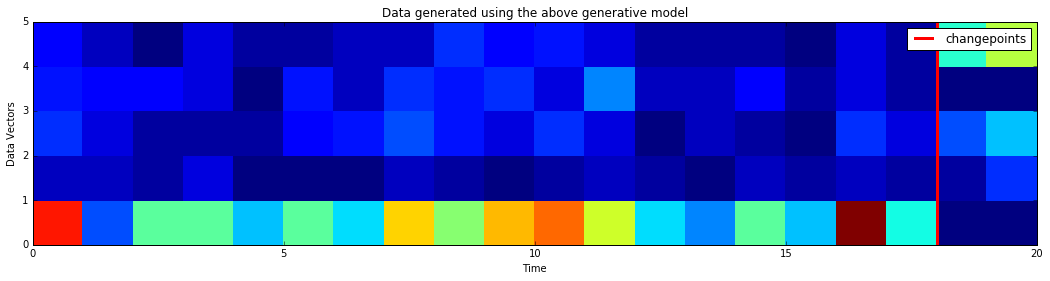

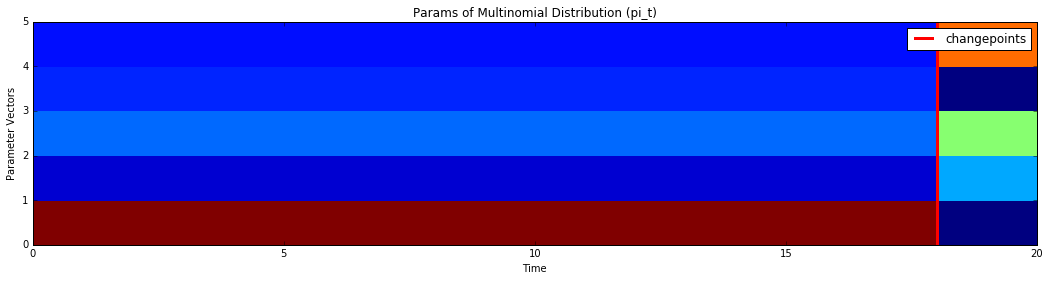

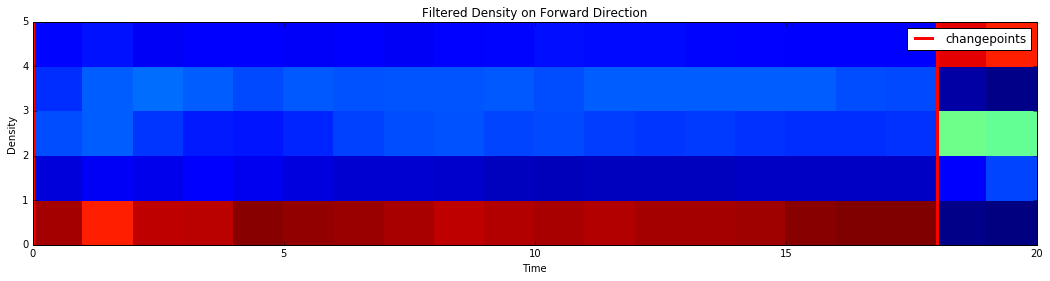

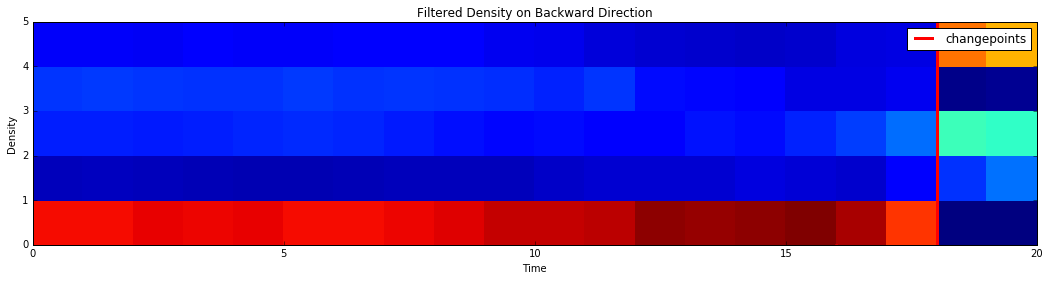

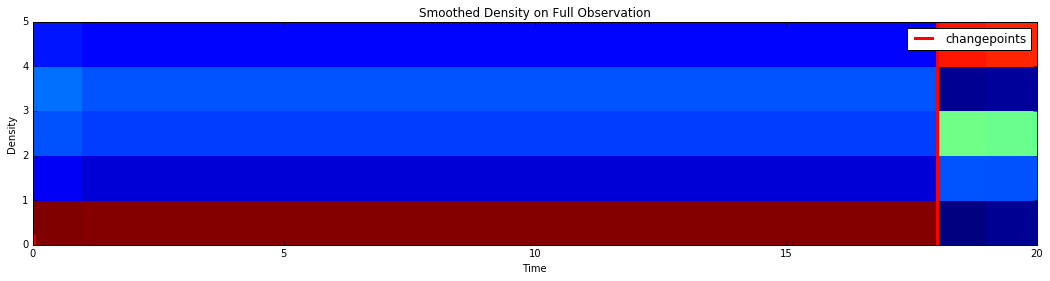

In [132]:
model = DirichletCPModel(r,np.random.random(K))
fb = ForwardBackward(model,L=0)

[alpha_predict, alpha_update, p_change_f, mean_f] = fb.forward(data)
[beta_postdict, beta_update, p_change_b, mean_b] = fb.backward(data)

model_output_forward = [i for i in range(T) if p_change_f[i]>0.5]
model_output_backward = [i for i in range(T) if p_change_b[i]>0.5]

print("actual_changepoints:\t {}".format(actual_changepoints))
print("model_output_forward:\t {}".format(model_output_forward))
print("model_output_backward:\t {}".format(model_output_backward))

plot_hist(data,ch,title="Data generated using the above generative model", xlabel="Time",ylabel="Data Vectors")
plot_hist(pi_,ch,title="Params of Multinomial Distribution (pi_t)", xlabel="Time",ylabel="Parameter Vectors")

plot_hist(mean_f,p_change_f,title="Filtered Density on Forward Direction", xlabel="Time",ylabel="Density")
plot_hist(mean_b,p_change_b,title="Filtered Density on Backward Direction", xlabel="Time",ylabel="Density")

[mean, p_change] = fb.smoothing(data)
plot_hist(mean,p_change,title="Smoothed Density on Full Observation", xlabel="Time",ylabel="Density")


## Parameter Learning

### The EM Algorithm

[see http://www.cs.princeton.edu/courses/archive/spr08/cos424/scribe_notes/0311.pdf for better writing]

The EM algorithm is a general method that is widely used to find the parameters of a state space model that maximizes the likelihood. If $\theta$, $z$ and $x$ denote model parameters, latent variables and observations, respectively, we can express our goal as follows:

\begin{align}
   \hat{\theta} = \underset{\theta}{\text{argmax}} \log p(x|\theta) = \underset{\theta}{\text{argmax}}  \log  \sum_{z} \underbrace{p(z|\theta) p(x|z,\theta)}_{complete-data-likelihood} 
\end{align}

The expression on the right is hard to evaluate as the summation over latent variables is almost always intractable. For this, classical EM algorithm attempts to maximize a lower bound for the likelihood. Now, let's first write the log-likelihood:

\begin{align}
    \log p(x|\theta) &= \log \sum_{z} p(z|\theta) p(x|z,\theta) \\
                     &= \log \sum_{z} p(z|\theta) p(x|z,\theta) \frac{q(z)}{q(z)} \\  
                     &= \log E \left[ \frac{p(z|\theta) p(x|z,\theta)}{q(z)} \right]_{q(z)} \\ 
                     &\geq E \left[ \log  \frac{p(z|\theta) p(x|z,\theta)}{q(z)} \right]_{q(z)} \\
                     &= E \left[ \log p(z|\theta) + \log p(x|z,\theta) - \log q(z) \right]_{q(z)} \\  
                  \mathcal{L}(\theta, q(z)) &= \underbrace{E \left[ \log p(z|\theta) \right]_{q(z)} + E \left[ \log p(x|z,\theta) \right]_{q(z)}}_{energy} - \underbrace{E \left[ \log q(z) \right]_{q(z)}}_{entropy} \\  
\end{align}

Here, $q(z)$ is an arbitrary distribution on $z$. Also note that we used the Jensen inequality, which states that $f(E[x]) \geq E[f(x)]$ when $f$ is a concave function (such as $\log$), in the fourth line. In each iteration of the algorithm, $q(z)$ and $\theta$ is updated to maximize current value of $\mathcal{L}(\theta, q(z))$. The algorithm terminates when the likelihood converges.

#### E-Step
In the classical EM, recipe for the E-step is ready. At $t$'th step,
\begin{equation}
    q(z)^{(t)} = p(z|x,\theta^{(t)})
\end{equation}

This choice makes the bound tight:
\begin{align}
    \mathcal{L}(p(z|x,\theta), \theta) &= E \left[ \log p(z|\theta) + \log p(x|z,\theta) - \log p(z|x,\theta) \right]_{p(z|x,\theta)} \\
    &= \sum_{z} p(z|x,\theta) \log \frac{p(x,z|\theta)}{p(z|x,\theta)} \\
    &= \sum_{z} p(z|x,\theta) \log p(x|\theta) \\
    &= \log p(x|\theta) \sum_{z} p(z|x,\theta)  \\
    &= \log p(x|\theta)
\end{align}

From now on, we will replace $\mathcal{L}(\theta, q(z))$ with $\mathcal{L}(\theta, \theta^{(t)})$ as $q(z)$ is a distribution conditioned to $\theta^{(t)}$.

#### M-Step
The M-Step updates the model parameter $\theta$ that maximizes the expected complete data log likelihood.
\begin{equation}
    \theta^{(t+1)} = \underset{\theta}{\text{argmax}} \mathcal{L}(\theta^{(t)}, \theta)
\end{equation}

### EM Applied to CPM

In the model, we have two parameters $\theta = (c,a)$ to learn: the prior probability of a change, $p(r=1)=c$ and the reset parameter $a$.

Let's first write down the log of complete data likelihood:

\begin{align}
    \log p(r_{1:T},\pi_{0:T}, x_{1:T} | \theta) &= \log p(r_{1:T} | \theta) + \log p(\pi_{0:T}|r_{1:T}, \theta) + \log p(x_{1:T}|r_{1:T},\pi_{0:T}, \theta) \\
    &= \left( \sum_{t=1}^T \log p(r_t|\theta) \right) + \left(  \log p(\pi_0|\theta) + \sum_{t=1}^T \log  p(\pi_t|\pi_{t-1}, r_t, \theta) \right) + \left( \sum_{t=1}^T p(x_t|\pi_t) \right) \\
    &= \left( \sum_{t=1}^T \log \left( c^{[r_t=1]} (1-c)^{[r_t=0]} \right) \right) + \left(  \log \text{Dir}(\pi_0;a) + \sum_{t=1}^T \log \left( \delta(\pi_t-\pi_{t-1})^{[r_t=0]} \text{Dir}(\pi_t;a)^{[r_t=1]} \right) \right) + \left( \sum_{t=1}^T \text{Mult}(x_t; \pi_t) \right) \\
    &= \left( \sum_{t=1}^T [r_t=1]\log c +  [r_t=0]\log(1-c) \right) + \left(  \log \text{Dir}(\pi_0;a) + \sum_{t=1}^T [r_t=0] \log \delta(\pi_t-\pi_{t-1}) + [r_t=1]\log \text{Dir}(\pi_t;a)  \right) + \left( \sum_{t=1}^T \text{Mult}(x_t; \pi_t) \right) \\
\end{align}

Then, we calculate expected complete data log-likelihood:

\begin{align}
    &\mathrm{E} \left[ \log p(r_{1:T},\pi_{0:T}, x_{1:T} | \theta) \right]_{p(r_{1:T},\pi_{0:T}|x_{1:T},\theta^{(t)})} \\
    &= \mathrm{E} \left[ \left( \sum_{t=1}^T [r_t=1]\log c +  [r_t=0]\log(1-c) \right) + \left(  \log \text{Dir}(\pi_0;a) + \sum_{t=1}^T [r_t=0] \log \delta(\pi_t-\pi_{t-1}) + [r_t=1]\log \text{Dir}(\pi_t;a)  \right) + \left( \sum_{t=1}^T \text{Mult}(x_t; \pi_t) \right)  \right]_{p(r_{1:T},\pi_{0:T}|x_{1:T},\theta^{(t)})} \\
\end{align}

Now, we consider each summation in the expectation separately. Note that last summation is omitted as it does not incorporate any model parameter to optimize.

**Here is the first term:**

\begin{align}
    \mathrm{E} \left[ \sum_{t=1}^T [r_t=1]\log c +  [r_t=0]\log(1-c) \right]_{p(r_{1:T},\pi_{0:T}|x_{1:T},\theta^{(t)})} &= \sum_{t=1}^T  \mathrm{E} \left[  [r_t=1]\log c +  [r_t=0]\log(1-c) \right]_{p(r_{1:T},\pi_{0:T}|x_{1:T},\theta^{(t)})}  \\
    &= \sum_{t=1}^T  \mathrm{E} \left[  [r_t=1]\log c +  [r_t=0]\log(1-c) \right]_{p(r_t|x_{1:T},\theta^{(t)})}  \\
    &= \sum_{t=1}^T  p(r_t=1|x_{1:T},\theta^{(t)})\log c +  p(r_t=0|x_{1:T},\theta^{(t)})\log(1-c)  \\
    &= \log c \sum_{t=1}^T  p(r_t=1|x_{1:T},\theta^{(t)})+  \log (1-c) \sum_{t=1}^T  p(r_t=0|x_{1:T},\theta^{(t)})  \\
\end{align}

We then took the derivative wrt $c$:

\begin{align}
    \frac{\partial \left( \log c \sum_{t=1}^T  p(r_t=1|x_{1:T},\theta^{(t)})+  \log (1-c) \sum_{t=1}^T  p(r_t=0|x_{1:T},\theta^{(t)}) \right) }{\partial c} &= 0 \\
    (1-c)\sum_{t=1}^T  p(r_t=1|x_{1:T},\theta^{(t)}) - c \sum_{t=1}^T  p(r_t=0|x_{1:T},\theta^{(t)}) &= 0 \\
    c = \frac{\sum_{t=1}^T p(r_t=1|x_{1:T},\theta^{(t)})}{T}
\end{align}

[http://www.msr-waypoint.com/en-us/um/people/minka/papers/dirichlet/minka-dirichlet.pdf]

**Concentrating on the second term, we have**

\begin{align}
    \mathrm{E} \left[ \log p(\pi_{0:T}|r_{1:T}, \theta) \right]_{p(r_{1:T},\pi_{0:T}|x_{1:T},\theta^{(t)})} &= \mathrm{E} \left[ \log \text{Dir}(\pi_0;a) + \sum_{t=1}^T [r_t=0] \log \delta(\pi_t-\pi_{t-1}) + [r_t=1]\log \text{Dir}(\pi_t;a) \right]_{p(r_{1:T},\pi_{0:T}|x_{1:T},\theta^{(t)})} \\
    &=  \mathrm{E} \left[ \log \text{Dir}(\pi_0;a) \right]_{p(r_{1:T},\pi_{0:T}|x_{1:T},\theta^{(t)})} + \mathrm{E} \left[ \sum_{t=1}^T [r_t=0] \log \delta(\pi_t-\pi_{t-1}) \right]_{p(r_{1:T},\pi_{0:T}|x_{1:T},\theta^{(t)})} + \mathrm{E} \left[ \sum_{t=1}^T [r_t=1]\log \text{Dir}(\pi_t;a)  \right]_{p(r_{1:T},\pi_{0:T}|x_{1:T},\theta^{(t)})} \\ 
    &=^+  \mathrm{E} \left[ \log \text{Dir}(\pi_0;a) \right]_{p(\pi_{0}|x_{1:T},\theta^{(t)})} + \sum_{t=1}^T \mathrm{E} \left[ [r_t=1]\log \text{Dir}(\pi_t;a)  \right]_{p(r_{1:T},\pi_{0:T}|x_{1:T},\theta^{(t)})} \\
    &=  \mathrm{E} \left[ \log \text{Dir}(\pi_0;a) \right]_{p(\pi_{0}|x_{1:T},\theta^{(t)})} + \sum_{t=1}^T  p(r_t=1|x_{1:T},\theta^{(t)}) \mathrm{E} \left[  \log \text{Dir}(\pi_t;a)  \right]_{p(\pi_t|x_{1:T},\theta^{(t)})}
\end{align}

To be more compact, let's define $p(r_0=1|x_{1:T},\theta^{(t)}) := 1$ and write the last line above as 
\begin{align}
    = \sum_{t=0}^T  p(r_t=1|x_{1:T},\theta^{(t)}) \mathrm{E} \left[  \log \text{Dir}(\pi_t;a)  \right]_{p(\pi_t|x_{1:T},\theta^{(t)})}
\end{align}

Let's also define $\pi_{t,k}$ as the $k$'th component of a vector $\pi_t \in \mathbf{R}^K$. In our context, $p(\pi_t|x_{1:T},\theta)$ corresponds to the posterior probability.

Now, take the derivative of the above expression wrt $a_k$, $k$'th component of a vector $a \in \mathbf{R}^K$ :

\begin{align}
    \frac{\partial}{\partial a_{k}}  \left( \mathrm{E} \left[ \log p(\pi_{0:T}|r_{1:T}, \theta) \right]_{p(r_{1:T},\pi_{0:T}|x_{1:T},\theta^{(t)})}\right) &= \frac{\partial} {\partial a_{k}}  \left\{  \sum_{t=0} p(r_t=1|x_{1:T},\theta^{(t)}) \mathrm{E} \left[  \log \text{Dir}(\pi_t;a)  \right]_{p(\pi_t|x_{1:T},\theta^{(t)})} \right\} \\
    &= \frac{\partial}{\partial a_{k}} \left\{ \sum_t p(r_t=1|x_{1:T},\theta^{(t)}) \mathrm{E} \left[ \sum_k (a_k-1) \log \pi_{t,k} +  \log \Gamma \left( \sum_k a_k \right) - \sum_k \log \Gamma(a_k) \right]_{p(\pi_t|x_{1:T},\theta^{(t)})} \right\} \\
    &= \frac{\partial}{\partial a_{k}} \left\{  \sum_t p(r_t=1|x_{1:T},\theta^{(t)}) \left( \int_{\pi_t} p(\pi_t|x_{1:T},\theta^{(t)}) \sum_k (a_k-1) \log \pi_{t,k} \text{d} \pi_t +  \log \Gamma \left( \sum_k a_k \right) - \sum_k\log \Gamma(a_k) \right)  \right\}\\
    &=  \sum_t p(r_t=1|x_{1:T},\theta^{(t)}) \left\{  \int_{\pi_t} p(\pi_t|x_{1:T},\theta^{(t)}) \frac{\partial \left( \sum_k (a_k-1) \log \pi_{t,k} \right)}{\partial a_{k}}  \text{d} \pi_t + \frac{\partial \log \Gamma \left( \sum_k a_k \right)}{\partial a_{k}} - \frac{\partial \sum_k\log \Gamma(a_k)}{\partial a_{k}}  \right\}  \\ 
    0 &= \sum_t p(r_t=1|x_{1:T},\theta^{(t)}) \left\{ \int_{\pi_t} p(\pi_t|x_{1:T},\theta^{(t)}) \log \pi_{t,k} \text{d} \pi_t + \psi \left( \sum_{k=1}^K a_k \right) - \psi (a_k) \right\} \\
    \sum_t p(r_t=1|x_{1:T},\theta^{(t)}) \int_{\pi_t} p(\pi_t|x_{1:T},\theta^{(t)}) \log \pi_{t,k} \text{d} \pi_t &= \sum_t p(r_t=1|x_{1:T},\theta^{(t)}) \left(  \psi (a_k) - \psi \left( \sum_{k=1}^K a_k \right) \right) \\
       \sum_t p(r_t=1|x_{1:T},\theta^{(t)}) \mathrm{E} [\log \pi_{t,k}] &= \left( \psi (a_k) - \psi \left( \sum_{k=1}^K a_k \right) \right) \sum_t  p(r_t=1|x_{1:T},\theta^{(t)}) 
\end{align}

If we set $\mathbf{C} = \sum_t p(r_t=1|x_{1:T},\theta^{(t)})$, the above expression becomes

\begin{equation}
    \frac{1}{\mathbf{C}} \sum_t p(r_t=1|x_{1:T},\theta^{(t)}) \mathrm{E} [\log \pi_{t,k}] = \psi (a_k) - \psi \left( \sum_{k=1}^K a_k \right)
\end{equation}

From here, we need to find an update equation for $a_k$, Luckily, Minka's paper derived the equation for estimating Dirichlet parameters. Applying the same idea, we reach to an iterative procedure:

\begin{align}
    \psi (a_k^{\text{new}}) = \frac{1}{\mathbf{C}} \sum_t p(r_t=1|x_{1:T},\theta^{(t)}) \mathrm{E} [\log \pi_{t,k}] +  \psi \left( \sum_{k=1}^K a_k^{\text{old}} \right)
\end{align}

Finally, we need to invert digamma function ($\psi$). See $\textbf{Appendix A}$ for the implementation.

a_true: [ 45.40207302  44.50963111  23.11279016  29.13139932  26.0455798
  43.59445312  26.19009857  21.411042     3.99428806  49.45912157]
c_true: 0.05
a_est : [ 17617.65514005  15676.71149389   7966.16027152  12593.77192705
   9099.47726596  15002.51190334   8685.42832879   6689.34201949
   1504.07875545  16567.39797696]
c_est : 0.169599429231


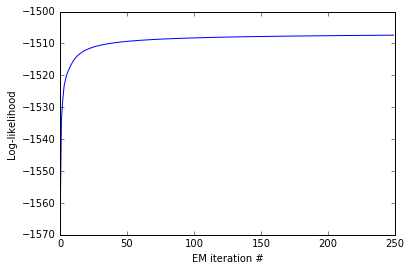

In [139]:
#########################
#### DATA GENERATION ####
#########################
T = 100
K = 5
c_true = 0.05
a_true = np.random.random(K)*50
[ch, pi_, data] = DirichletCPModel.gen_sequence(c_true, a_true, T=100)
    
#########################
###### EM ALGORITHM #####
#########################
# constants
MAX_ITER = 50
INV_DIG_ITER = 100

# initial change point model 
c = 0.25
a = np.random.random(K)*10
fb = ForwardBackward(DirichletCPModel(c, a))
loglhoods = np.zeros(MAX_ITER)

for i in range(MAX_ITER):
    # log-likelihood calculation
    norm_consts = ForwardBackward.loglhood(c, a, data)
    loglhoods[i] = safe_log_sum_exp(norm_consts)
    
    # E step and sufficient stats
    [mean, cpp] = fb.smoothing(data)
    log_nor_mean = np.log( mean/mean.sum(0) )
    ss = (log_nor_mean*cpp).sum(1) / np.sum(cpp)
    
    # M step
    c = np.sum(cpp)*1.0/T
    for it in range(INV_DIG_ITER):
        a_new = np.zeros(a.size)
        for j in range(a.size):
            a_new[j] = inv_digamma( ss[j]+sp.digamma(a.sum()) )
        a = a_new  
    fb = ForwardBackward(DirichletCPModel(c, a))

# results    
print("a_true:", a_true)
print("c_true:", c_true)
print("a_est :",a)
print("c_est :",c)

plt.plot(loglhoods)
plt.ylabel("Log-likelihood")
plt.xlabel("EM iteration #")
plt.show()



## Appendix A

### Estimating Dirichlet Distribution

Say we have a $N$ random vectors $\{p^1, p^2, \dots p^N\}$ drawn from a Dirichlet distribution with unknown parameter $a$, where each vector is $K$ dimensional, $p_k^n \geq 0$ and $\sum_k p_k^n=1$ for $n \in 1 \dots N$ and $k \in 1 \dots K$. 

The unknown parameter $a$ can be estimated using EM-like updates (noted in Minka's paper). Given an initial guess for $a$, each component of $a$ is estimed iteratively as follows:

\begin{align}
    \psi (a_k^{\text{new}}) = \mathrm{E} [\log \bar p_k] +  \psi \left( \sum_{k=1}^K a_k^{\text{old}} \right)
\end{align}

where $\log \bar p_k$ is the sufficient statistics

\begin{align}
    \log \bar p_k = \frac{1}{N} \sum_n p_k^n
\end{align}

To calculate $a_k^{\text{new}}$, we need the invert the digamma function. Newton's iteration to invert the function was again given in Minka's paper. Below method $\textbf{inv_digamma}$ performs the inversion very quickly as it starts the iterations with good initial values:

In [85]:
# given y, returns x, where y = \psi(x)
def inv_digamma(y):
    if y > -2.22:
        x = np.exp(y) + 0.5
    else:
        x = -1/(y-sp.digamma(1))
    for i in range(5):
        x = x - (sp.digamma(x)-y)/sp.polygamma(1,x)
    return x

3.2031714683769312

Below is the code to estimate Dirichlet parameters:

In [26]:
alpha = np.array([10, 20, 30, 40])   # <---- trying to estimate this
N = 10000
MAX_ITER = 1000

logdata = np.log(np.random.dirichlet(alpha,N))
emp_exp = logdata.sum(0)/N
# print("empirical expectation:", emp_exp)

a = np.random.random(alpha.size)
for it in range(MAX_ITER):
    for i in range(alpha.size):
        a[i] = inv_digamma( emp_exp[i]+sp.digamma(a.sum()) )
    if np.mod(it,100) == 0:
        print(a)

[ 0.41361916  0.59588361  0.76703269  0.99944735]
[  9.06607571  18.12372225  27.14661167  36.18566784]
[  9.95781618  19.95235187  29.8970668   39.84081063]
[ 10.04838119  20.13807436  30.17641448  40.21204132]
[ 10.05757417  20.15692656  30.20477033  40.24972398]
[ 10.05850728  20.1588401   30.20764851  40.25354885]
[ 10.05860199  20.15903433  30.20794065  40.25393707]
[ 10.0586116   20.15905404  30.2079703   40.25397648]
[ 10.05861258  20.15905604  30.20797331  40.25398048]
[ 10.05861268  20.15905625  30.20797361  40.25398089]


In [79]:
from scipy import special
import numpy as np

alpha = np.array([25,44,11,20])
N = 100000

# monte carlo simulation of E[log \pi_k]
logdata = np.log(np.random.dirichlet(alpha,N))
avlogdata = logdata.sum(0)/N
print("monte carlo:\t ", avlogdata)

# exact expectation via digamma function
exp_= np.array([special.digamma(alpha_i)-special.digamma(alpha.sum()) for alpha_i in alpha])
print("true expectation:", exp_)

monte carlo:	  [-1.40050795 -0.82775747 -2.24991997 -1.6293184 ]
true expectation: [-1.40141934 -0.8273789  -2.24840926 -1.62963786]


In [28]:
# c++ changepoint kodunu deneme amacli, oradaki is bitince bu cell'i sil

def load_array(filename):
    X = np.loadtxt(filename)
    dim = int(X[0]);
    size = []
    for i in range(dim):
        size.append(int(X[i+1]));    
    X = np.reshape(X[dim+1:], size, order='F')
    return X;
    
data = load_array("/home/cagatay/Dropbox/Academic_Stuff/MyGithubRepos/my_changepoint(copy)/bin/data.txt")

(K,T) = data.shape
r = 0.05

model = DirichletCPModel(r,np.ones(K))
fb = ForwardBackward(model,L=0)

[mean, p_change] = fb.smoothing(data)
print(p_change)

FileNotFoundError: [Errno 2] No such file or directory: '/home/cagatay/Dropbox/Academic_Stuff/MyGithubRepos/my_changepoint(copy)/bin/data.txt'